### Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn.preprocessing

from wavemap_paper.helper_functions import RAND_STATE, set_rand_state, plot_inverse_mapping
from umap import umap_ as umap
import networkx as nx
import cylouvain

import plotly.express as px
from matplotlib import cm
from matplotlib import pyplot as plt

import utils__config

c:\Users\lal85\AppData\Local\miniconda3\envs\wavemap\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_rand_state(RAND_STATE)

In [3]:
os.chdir(utils__config.working_directory)
os.getcwd()

'Z:\\Layton\\Sleep_083023'

### Parameters

In [4]:
recordings = [
    {
        'recording_id': 'Feb02',
        'recording_length': 2,
        'spike_response_path': 'Cache/Subject01/Feb02/S01_unit_response.csv',
        'spike_forms_path': 'Cache/Subject01/Feb02/S01_spikeforms.csv'
    },
    {
        'recording_id': 'Jul11',
        'recording_length': 9.68,
        'spike_response_path': 'Cache/Subject05/Jul11/S05_unit_response.csv',
        'spike_forms_path': 'Cache/Subject05/Jul11/S05_spikeforms.csv'
    },
    {
        'recording_id': 'Jul12',
        'recording_length': 10.55,
        'spike_response_path': 'Cache/Subject05/Jul12/S05_unit_response.csv',
        'spike_forms_path': 'Cache/Subject05/Jul12/S05_spikeforms.csv'
    },
    {
        'recording_id': 'Jul13',
        'recording_length': 10.40,
        'spike_response_path': 'Cache/Subject05/Jul13/S05_unit_response.csv',
        'spike_forms_path': 'Cache/Subject05/Jul13/S05_spikeforms.csv'
    }
]

output_path = 'Cache/wavemap_results.csv'

### Load Data

In [5]:
# Empty lists to store dataframes for waveforms and times
waveforms_dfs = []
responses_dfs = []

# Process each recording
for recording in recordings:
    # Load and process waveforms
    waveforms = pd.read_csv(recording['spike_forms_path'])
    waveforms = waveforms[['unit_id', 'time_point', 'amplitude']]
    waveforms.columns = ['unit_id_old', 'time_point', 'amplitude']
    waveforms['unit_id'] = waveforms['unit_id_old'].astype(str) + '_' + recording['recording_id']
    waveforms_dfs.append(waveforms)

    # Load and process responses
    responses = pd.read_csv(recording['spike_response_path'])
    responses = responses[['unit', 'unit_roi', 'response_type']]
    responses.columns = ['unit_id_old', 'unit_roi', 'response']
    responses['unit_id'] = responses['unit_id_old'].astype(str) + '_' + recording['recording_id']
    responses_dfs.append(responses)

# Concatenate all dataframes for waveforms and times
data = pd.concat(waveforms_dfs, ignore_index=True)
response = pd.concat(responses_dfs, ignore_index=True)

# Pivot data
wide_df = data.pivot(index = 'unit_id', columns = 'time_point', values = 'amplitude')
wide_df = wide_df.reset_index()

# Convert to numpy array
unnormWFs = wide_df.iloc[:, 1:].to_numpy()

In [6]:
response

,unit_id_old,unit_roi,response,unit_id
0,S01_Ch195_neg_Unit3,R CLA,Positive,S01_Ch195_neg_Unit3_Feb02
1,S01_Ch195_pos_Unit2,R CLA,Positive,S01_Ch195_pos_Unit2_Feb02
2,S01_Ch196_neg_Unit1,R CLA,Positive,S01_Ch196_neg_Unit1_Feb02
3,S01_Ch196_neg_Unit3,R CLA,Positive,S01_Ch196_neg_Unit3_Feb02
4,S01_Ch196_neg_Unit4,R CLA,Positive,S01_Ch196_neg_Unit4_Feb02
...,...,...,...,...
117,S05_Ch238_neg_Unit1,R AMY,Negative,S05_Ch238_neg_Unit1_Jul13
118,S05_Ch238_neg_Unit2,R AMY,Negative,S05_Ch238_neg_Unit2_Jul13
119,S05_Ch239_neg_Unit2,R AMY,Negative,S05_Ch239_neg_Unit2_Jul13
120,S05_Ch240_neg_Unit2,R AMY,Negative,S05_Ch240_neg_Unit2_Jul13


### Normalization

In [7]:
# Transpose meanSubWFs for normalization
meanSubWFs = unnormWFs.T - np.mean(unnormWFs, axis = 1)
normWFs = sklearn.preprocessing.normalize(meanSubWFs.T, norm = 'max')
normWFs

# Convert wide format to long format
df = pd.DataFrame(normWFs.T).reset_index().melt(id_vars='index', var_name='Neuron', value_name='Value')

### WaveMAP

In [8]:
# WaveMAP
reducer = umap.UMAP(random_state = RAND_STATE, n_neighbors = 15)
mapper = reducer.fit(normWFs)

# NetworkX
G = nx.from_scipy_sparse_array(mapper.graph_)

# Louvain Clustering
clustering = cylouvain.best_partition(G, resolution = 2)
clustering_solution = list(clustering.values())

adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


### Inverse Transform and Add Meta-Data

In [9]:
embedding = reducer.fit_transform(normWFs)
umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
umap_df['waveform'] = list(normWFs)
umap_df['cluster_id'] = clustering_solution

In [10]:
wavemap_df = pd.concat([umap_df, wide_df.unit_id], axis = 1)
wavemap_df = wavemap_df.merge(response[['unit_id', 'unit_id_old', 'unit_roi', 'response']], on = 'unit_id')
wavemap_df.to_csv(output_path, index = False)

### Plotting

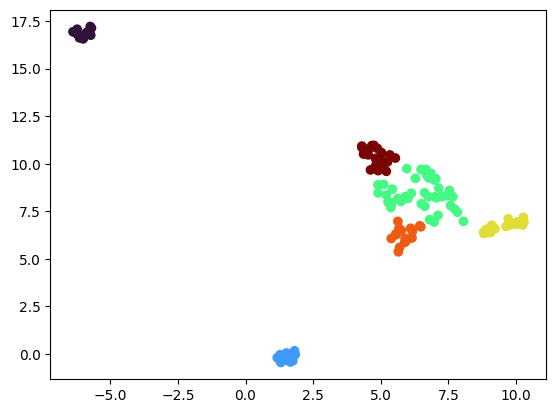

In [11]:
cmap = plt.get_cmap("turbo")
colors = cmap(np.linspace(0, 1, len(set(clustering_solution))))
umap_df['cluster_color'] = [colors[i] for i in clustering_solution]
plt.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(),
marker='o', c=umap_df['cluster_id'].tolist(), cmap='turbo')

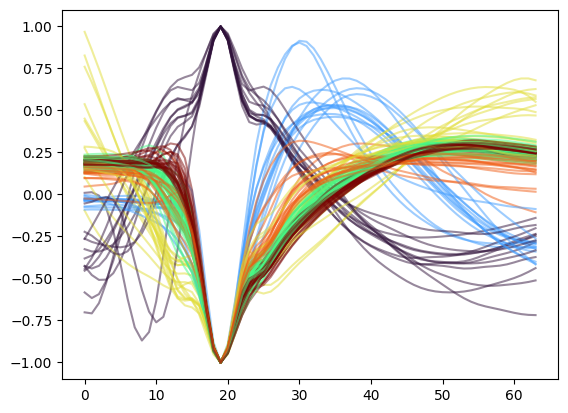

In [12]:
f,arr = plt.subplots(1)
for i,row in enumerate(umap_df['waveform'].tolist()):
    arr.plot(umap_df['waveform'].tolist()[i],
            c=umap_df['cluster_color'].tolist()[i],
            alpha=0.5)

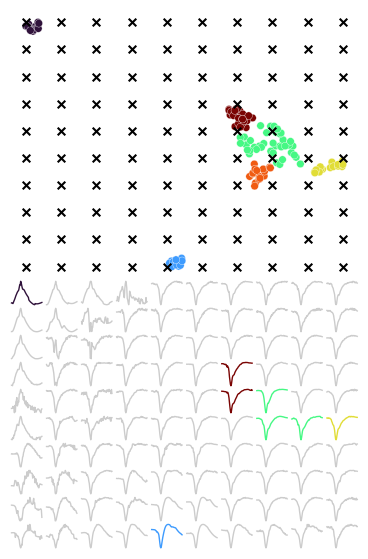

In [13]:
plot_inverse_mapping(reducer, umap_df)